# 請結合前面的知識與程式碼，比較不同的 optimizer 與 learning rate 組合對訓練的結果與影響
### 常見的 optimizer 包含
* SGD
* RMSprop
* AdaGrad
* Adam

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [26]:
def build_mlp(input_shape, output_num=10, num_neurons=[512, 256, 128, 64, 32]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, neurons in enumerate(num_neurons):
        if i == 0:
            input_data = input_layer
        else:
            input_data = x
            
        x = keras.layers.Dense(units=neurons, activation='relu', name='hidden_layer' + str(i + 1))(input_data)
    
    out = keras.layers.Dense(units=output_num, activation='softmax', name='output')(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    
    return model

In [29]:
def train_model(epochs, batch_size, momentum, optimizer):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("EPOCHS:%d, BATCH_SIZE:%d, MOMENTUM:%.4f, OPTIMIZER:%s\n" % (epochs, batch_size, momentum, optimizer))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    
    model.fit(x_train, y_train, 
              epochs=epochs, 
              batch_size=batch_size, 
              validation_data=(x_test, y_test), 
              verbose=0,
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-optimizer-%s" % optimizer
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}
    return results

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

def plotHistory(history):
    plt.figure(figsize=(8,6))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond)
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond)
    plt.title("Loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(8,6))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond)
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond)
    plt.title("Accuracy")
    plt.legend()
    plt.show()
    
    

In [10]:
## 超參數設定
"""
Set your required experiment parameters
"""
epochs = 50
batch_size = 128
momentum = 0.9
optimizer_list = ['sgd', 'rmsprop', 'adam', 'adagrad']

EPOCHS:50, BATCH_SIZE:128, MOMENTUM:0.9000, OPTIMIZER:sgd

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
hidden_layer4 (Dense)        (None, 64)                8256      
_________________________________________________________________
hidden_layer5 (Dense)        (None, 32)                2080      
_________________________________________________________________
output (Dense)   

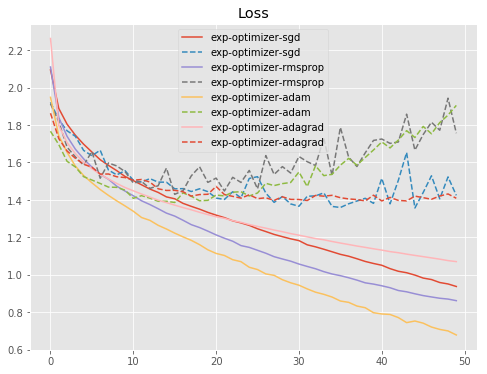

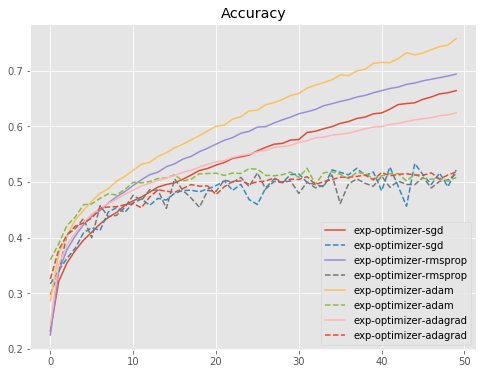

In [30]:
results = {}
"""
建立你的訓練與實驗迴圈並蒐集資料
"""
for optimizer in optimizer_list:
    results.update(train_model(epochs=epochs, batch_size=batch_size, momentum=momentum, optimizer=optimizer))

plotHistory(results)

* 從上面可以看到，使用 adam 可以得到最好的結果，不論是在 loss function 的降低上，或者是預測的準確度上都有最好的呈現結果。